In [79]:
### Project 2 Airbnb Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as pp
import glob
import datetime
import matplotlib.ticker as mtick

import plotly
import plotly.plotly as py
py.sign_in('nzahadat', 'VDBLh2LQZvNWxovGAbr8')
print(plotly.__version__)
plotly.offline.init_notebook_mode() # run at the start of every notebook


%matplotlib inline

2.0.11


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [2]:
# import & conbine data
total_listings=pd.DataFrame()
for filename in glob.iglob('./**/**/listings.csv',recursive=False):
    print(filename)
    data=pd.read_csv(filename,error_bad_lines=False,low_memory=False,encoding='ISO-8859-1')
    total_listings=total_listings.append(data)
    
    

.\2015-01-01\data\listings.csv
.\2015-03-01\data\listings.csv
.\2015-04-01\data\listings.csv
.\2015-05-01\data\listings.csv
.\2015-06-01\data\listings.csv
.\2015-08-01\data\listings.csv
.\2015-09-01\data\listings.csv
.\2015-10-01\data\listings.csv
.\2015-11-01\data\listings.csv
.\2015-12-02\data\listings.csv
.\2016-01-01\data\listings.csv
.\2016-02-02\data\listings.csv
.\2016-04-03\data\listings.csv
.\2016-05-02\data\listings.csv
.\2016-06-02\data\listings.csv
.\2016-07-02\data\listings.csv
.\2016-08-02\data\listings.csv
.\2016-09-02\data\listings.csv
.\2016-10-01\data\listings.csv
.\2016-11-02\data\listings.csv
.\2016-12-03\data\listings.csv
.\2017-01-01\data\listings.csv
.\2017-02-02\data\listings.csv
.\2017-03-02\data\listings.csv
.\2017-04-02\data\listings.csv
.\2017-05-02\data\listings.csv


In [3]:
# create row index as id + calendar_last_scraped
total_listings['id_date']=total_listings['id'].map(str)+"_"+total_listings['last_scraped']
total_listings=total_listings.set_index(['id_date'])

In [4]:
total_listings.shape

(908730, 96)

In [5]:
total_listings.isnull().sum()/total_listings.shape[0]*100

access                              69.266339
accommodates                         0.000000
amenities                           15.042092
availability_30                      0.000330
availability_365                     0.000330
availability_60                      0.000330
availability_90                      0.000330
bathrooms                            0.752039
bed_type                             0.000000
bedrooms                             0.254421
beds                                 0.225259
calculated_host_listings_count       3.014317
calendar_last_scraped                0.000000
calendar_updated                     0.000000
cancellation_policy                 15.042092
city                                 0.083523
cleaning_fee                        41.881417
country                              0.000110
country_code                        15.042092
description                          3.042378
experiences_offered                 15.042092
extra_people                      

In [6]:
total_listings['state'].unique()

array(['NY', nan, 'Queens NY 11377, USA', 'Ny', 'ny', 'CA', 'OR', 'OK',
       'MP', 'DO', 'NJ', 'New York', 'FL', 'CO', 'bx', 'DC', 'VT', 'MA'], dtype=object)

In [7]:
# drop rows where state is not NY, ny, Ny, New York, Queens NY 11377, USA, and bx
total_listings=total_listings.loc[total_listings['state'].isin(['NY', 'ny', 'Ny','New York','Queens NY 11377, USA', 'bx'])]


In [8]:
# check state again
total_listings['state'].unique()

array(['NY', 'Queens NY 11377, USA', 'Ny', 'ny', 'New York', 'bx'], dtype=object)

In [9]:
# clean the price formatting
total_listings['price'] = total_listings['price'].map(lambda p: int(p[1:-3].replace(",", "")))
total_listings['price'].dtype

dtype('int64')

In [10]:
# drop columns which have missing value over 20% and columns that are not related to analysis

total_listings_clean=total_listings.dropna(thresh=0.80*total_listings.shape[0],axis=1)
total_listings_clean.dropna(how='all', inplace=True)
total_listings_clean=total_listings_clean.drop(['calendar_updated','country_code','country','experiences_offered',
                                                'host_total_listings_count','market','neighbourhood','neighbourhood_group_cleansed',
                                                'scrape_id','smart_location','street','summary','host_picture_url',
                                               'host_thumbnail_url','host_url','listing_url','picture_url',
                                                'calendar_last_scraped'],axis=1)

C:\Users\Cyrax\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [11]:
list(total_listings_clean)

['accommodates',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bathrooms',
 'bed_type',
 'bedrooms',
 'beds',
 'calculated_host_listings_count',
 'cancellation_policy',
 'city',
 'description',
 'extra_people',
 'guests_included',
 'host_has_profile_pic',
 'host_id',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings_count',
 'host_location',
 'host_name',
 'host_since',
 'host_verifications',
 'id',
 'instant_bookable',
 'is_location_exact',
 'last_scraped',
 'latitude',
 'longitude',
 'maximum_nights',
 'minimum_nights',
 'name',
 'neighbourhood_cleansed',
 'number_of_reviews',
 'price',
 'property_type',
 'require_guest_phone_verification',
 'require_guest_profile_picture',
 'requires_license',
 'room_type',
 'state',
 'zipcode']

In [13]:
# convert features to boolean
for feature in ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact', 'requires_license', 'instant_bookable',
                   'require_guest_profile_picture', 'require_guest_phone_verification']:
    total_listings_clean[feature] = total_listings_clean[feature].map(lambda s: False if s == "f" else True)

In [14]:
# create dummmies for property characteristics
features = pd.DataFrame()
for feature in ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']:
    features = pd.concat([features, pd.get_dummies(total_listings_clean[feature])], axis=1)

#total_listings_clean.drop(['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type'],axis=1, inplace=True)
total_listings_clean=total_listings_clean.merge(features,left_index=True,right_index=True)


In [15]:
# parse amenities
total_listings_clean.amenities = total_listings_clean.amenities.str.replace("[{}]", "")
total_listings_clean.amenities = total_listings_clean.amenities.str.replace('"', '')
amenities = total_listings_clean.amenities.str.get_dummies(sep = ",")


In [16]:
amenities.shape


(908557, 122)

In [17]:
amenities


,24-Hour Check-in,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air Conditioning,Air conditioning,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,...,Wheelchair Accessible,Wheelchair accessible,Wide clearance to bed,Wide clearance to shower and toilet,Wide doorway,Wide hallway clearance,Window guards,Wireless Internet,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
id_date,,,,,,,,,,,,,,,,,,,,,
1069266_2015-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1846722_2015-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2061725_2015-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44974_2015-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4701675_2015-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68914_2015-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4832596_2015-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2562510_2015-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3005360_2015-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
feature

'bed_type'

In [18]:
# merge edited amenities back to total_listings
total_listings_clean_ame=total_listings_clean.merge(amenities,left_index=True,right_index=True)
total_listings_clean_ame.dropna(subset=['amenities'], inplace=True) 
total_listings_clean_ame.drop(['amenities'],axis=1, inplace=True)
total_listings_clean_ame

,accommodates,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,...,Wheelchair Accessible,Wheelchair accessible,Wide clearance to bed,Wide clearance to shower and toilet,Wide doorway,Wide hallway clearance,Window guards,Wireless Internet,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
id_date,,,,,,,,,,,,,,,,,,,,,
4622922_2015-08-01,2,0.0,212.0,0.0,0.0,1.0,Real Bed,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
958444_2015-08-01,4,5.0,279.0,5.0,6.0,1.0,Real Bed,1.0,2.0,1.0,...,0,0,0,0,0,0,0,1,0,0
3943387_2015-08-01,2,0.0,326.0,21.0,51.0,1.0,Real Bed,1.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
3362669_2015-08-01,2,20.0,347.0,42.0,72.0,1.0,Real Bed,1.0,2.0,1.0,...,0,0,0,0,0,0,0,1,0,0
6627449_2015-08-01,3,6.0,309.0,8.0,34.0,1.0,Real Bed,1.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
5557381_2015-08-01,4,16.0,339.0,41.0,71.0,1.0,Real Bed,1.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
1886820_2015-08-01,4,0.0,239.0,0.0,0.0,3.0,Real Bed,3.0,3.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4462008_2015-08-01,2,4.0,319.0,17.0,44.0,1.0,Real Bed,1.0,2.0,4.0,...,0,0,0,0,0,0,0,1,0,0
260566_2015-08-01,2,3.0,155.0,3.0,3.0,1.0,Real Bed,1.0,2.0,5.0,...,0,0,0,0,0,0,0,1,0,0


In [20]:
total_listings_clean_ame.to_csv('data.csv')

In [21]:
list(total_listings_clean)

['accommodates',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bathrooms',
 'bed_type',
 'bedrooms',
 'beds',
 'calculated_host_listings_count',
 'cancellation_policy',
 'city',
 'description',
 'extra_people',
 'guests_included',
 'host_has_profile_pic',
 'host_id',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings_count',
 'host_location',
 'host_name',
 'host_since',
 'host_verifications',
 'id',
 'instant_bookable',
 'is_location_exact',
 'last_scraped',
 'latitude',
 'longitude',
 'maximum_nights',
 'minimum_nights',
 'name',
 'neighbourhood_cleansed',
 'number_of_reviews',
 'price',
 'property_type',
 'require_guest_phone_verification',
 'require_guest_profile_picture',
 'requires_license',
 'room_type',
 'state',
 'zipcode',
 'Allerton',
 'Alphabet City',
 'Arden Heights',
 'Arrochar',
 'Arverne',
 'Astoria',
 'Bath Beach',
 'Battery Park City',
 'Bay Ridge',
 'Bay Terrace',
 'Bay Terrace, Staten Island',
 'Bayche

In [50]:
# number of listings over time
total_listings['date']=pd.to_datetime(total_listings['last_scraped']).dt.strftime('%Y-%m')
data_number_of_listings=total_listings.groupby(['date']).size()
data_number_of_listings.head()

date
2015-01    27390
2015-03    27097
2015-04    27408
2015-05    27316
2015-06    27465
dtype: int64

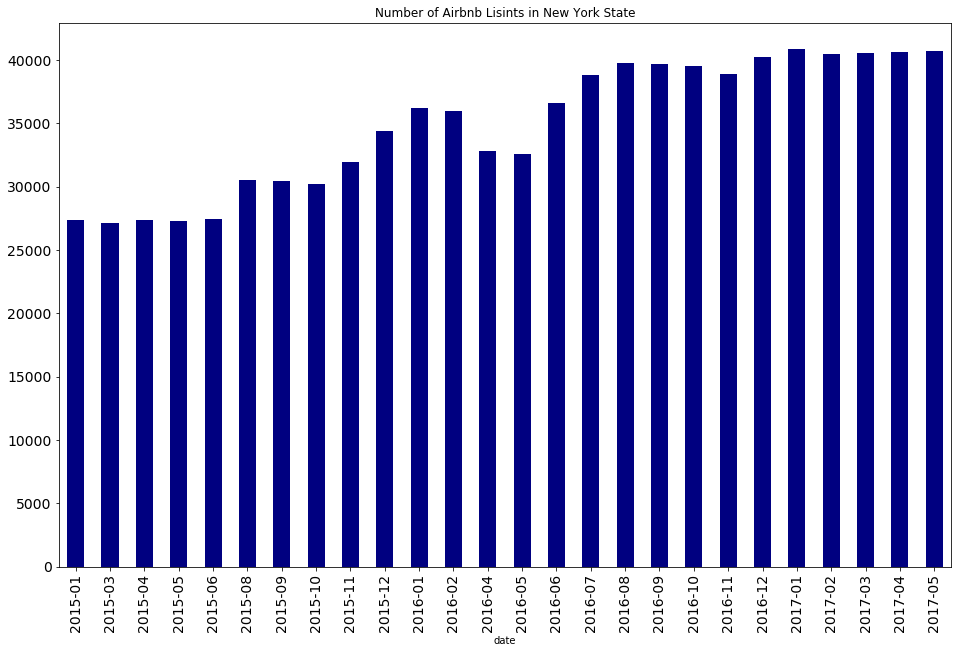

In [47]:
# graph number of listings over time
data_number_of_listings.plot(kind='bar',figsize=(16,10),legend=False, color='navy',fontsize=14,
                             title='Number of Airbnb Lisints in New York State')


In [82]:
# total size of listings in squared feet over time: approximated by using number of bedrooms and bathrooms
total_listings['size']=(total_listings['bedrooms']+0.5*total_listings['bathrooms'])*150
data_size_of_listings=total_listings[['date','size']].dropna(0)
data_size_of_listings=data_size_of_listings.groupby('date').sum()


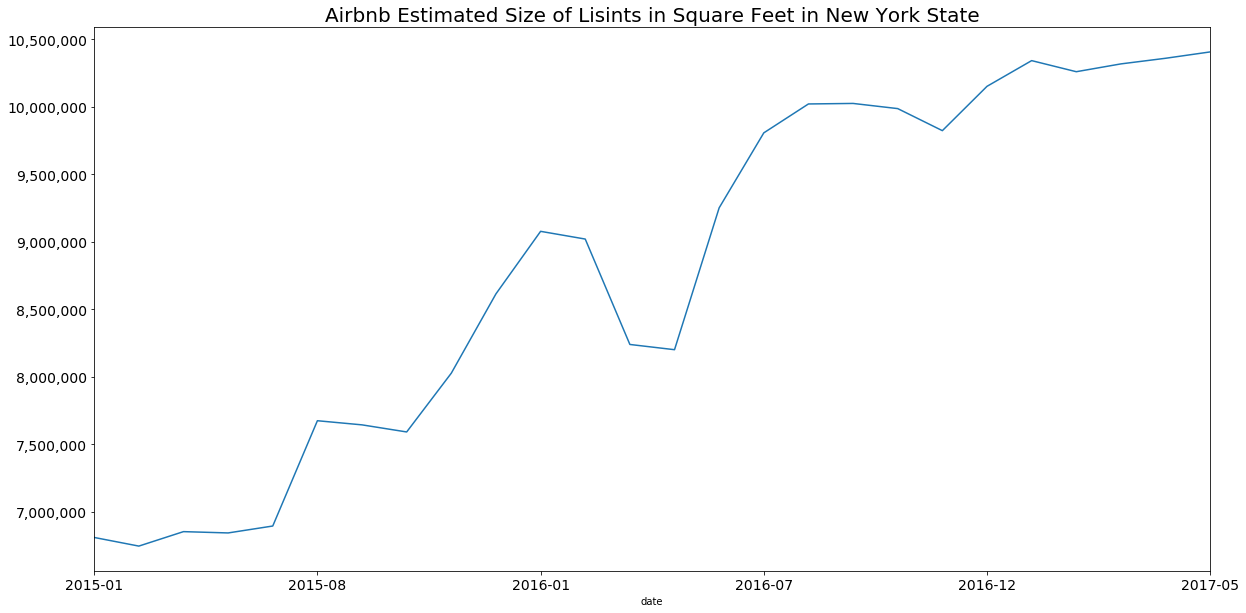

In [87]:
# graph size of listings over time
ax=data_size_of_listings.plot(figsize=(20,10),fontsize=14,legend=False)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.set_title('Airbnb Estimated Size of Lisints in Square Feet in New York State',fontsize=20)

In [ ]:
# listing room type percentage in May 2017
dates=total_listings_clean['date'].unique()
for date in dates:
    room_type=total_listings_clean[total_listings_clean['date']==date].sum()/len(total_listings_clean[total_listings_clean['date']==date])
    #data_room_type=room_type[['Entire home/apt', 'Private room', 'Shared room']]
    #data_room_type=data_room_type.append(data_room_type)

In [110]:
dates=total_listings_clean['date'].unique()

In [113]:
dates

array(['2015-01', '2015-03', '2015-04', '2015-05', '2015-06', '2015-08',
       '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02',
       '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09',
       '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03',
       '2017-04', '2017-05'], dtype=object)

In [ ]:
total_listings_clean[total_listings_clean['date']==dates.loc[1:1]]